In [1]:
%load_ext autoreload
%autoreload 3 --log
%autoreload?

Docstring:
::

  %autoreload [-p] [-l] [--hide-errors] [mode]

%autoreload => Reload modules automatically

%autoreload or %autoreload now
Reload all modules (except those excluded by %aimport) automatically
now.

%autoreload 0 or %autoreload off
Disable automatic reloading.

%autoreload 1 or %autoreload explicit
Reload only modules imported with %aimport every time before executing
the Python code typed.

%autoreload 2 or %autoreload all
Reload all modules (except those excluded by %aimport) every time
before executing the Python code typed.

%autoreload 3 or %autoreload complete
Same as 2/all, but also but also adds any new objects in the module. See
unit test at IPython/extensions/tests/test_autoreload.py::test_autoload_newly_added_objects

The optional arguments --print and --log control display of autoreload activity. The default
is to act silently; --print (or -p) will print out the names of modules that are being
reloaded, and --log (or -l) outputs them to the log at INFO level.

In [2]:
import torch

if False: # torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")
    torch.set_default_device(device)

torch.set_default_dtype(torch.float64)

print(f"Using device: {device}")

Using device: cpu


In [3]:
# Define model hyperparameters

from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet

gamma = 0.5
kappa = 1.0
d = 2
dt = 30
kernel = KernelFunction(
    kernel_name="squared_exponential", gamma=gamma, kappa=kappa, d=d
)
domain = BorelSet(d, bounds=torch.tensor([[-1.0, 1.0], [-1, 1]]).double())

In [4]:
# Define ground Truth Model

from stpy.continuous_processes.truncated_gp import TruncatedGP
from stpy.point_processes.poisson.poisson import PoissonPointProcess

gp = TruncatedGP(kernel, d)
process = PoissonPointProcess(2, 1e6, 1e-6, gp, naive_integral=True)

In [5]:
from validation import check_approx_squared_integral_difference
from validation import plot_approximation

import numpy as np
from stpy.borel_set import HierarchicalBorelSets
from stpy.embeddings.triangle_base import EfficientTriangleEmbedding
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
from validation import plot_approximation

In [6]:
dataset = None

In [8]:
# Basis that is optimal for upper right corner

# The points we're ultimately interested in
nodes = BorelSet(d, bounds=torch.tensor([[-0, 1.0], [0, 1]]).double()).return_discretization(60)
# nodes = torch.cat((nodes, torch.tensor([[-1, -1], [-1, 1], [1, -1], [1,1]]).double()))

m = 10
min_intensity = 0.0
max_intensity = 1e7
offset = 0.1
jitter = 1e-7
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    basis="optimal-positive",
    samples_nystrom=500,
    roi=nodes,
)

diff, dataset = check_approx_squared_integral_difference(
    process,
    estimator,
    domain,
    60,
    60,
    dt=dt,
    dataset=dataset if "dataset" in locals() else None,
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

Optimal basis with arbitrary dimension, namely d = 2
Starting optimal basis construction, with m = 10


Burn-In: 100%|██████████| 30/30 [00:04<00:00,  6.01it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 500/500 [01:26<00:00,  5.79it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Optimal basis constructed.
Precomputation finished.
Sampling from the Ground Truth Poisson Process


Burn-In: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00, 29.25it/s]
total number of velocity samples: 1: 


: 

In [10]:
# Basis that is optimal everywhere

# The points we're ultimately interested in
_, nodes = domain.return_legendre_discretization(60)

m = 9
min_intensity = 0.0
max_intensity = 1e7
offset = 0.1
jitter = 1e-7
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    basis="optimal-positive",
    samples_nystrom=500,
    roi=nodes,
)

diff, dataset = check_approx_squared_integral_difference(
    process,
    estimator,
    domain,
    60,
    60,
    dt=dt,
    dataset=dataset if "dataset" in locals() else None,
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

Optimal basis with arbitrary dimension, namely d = 2
Starting optimal basis construction, with m = 25
Optimal basis constructed.
Precomputation finished.
Sampling from the Ground Truth Poisson Process


Burn-In: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
total number of velocity samples: 1: 


Loading 126 Sampled Data points into approximate intensity model
nodes of functions torch.Size([25, 2])


/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


Approximating the integral of the squared difference between the ground truth intensity and its approximation


Burn-In: 100%|██████████| 30/30 [00:01<00:00, 23.29it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]
total number of velocity samples: 1: 


KeyboardInterrupt: 

/tmp/ipykernel_99464/888018221.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


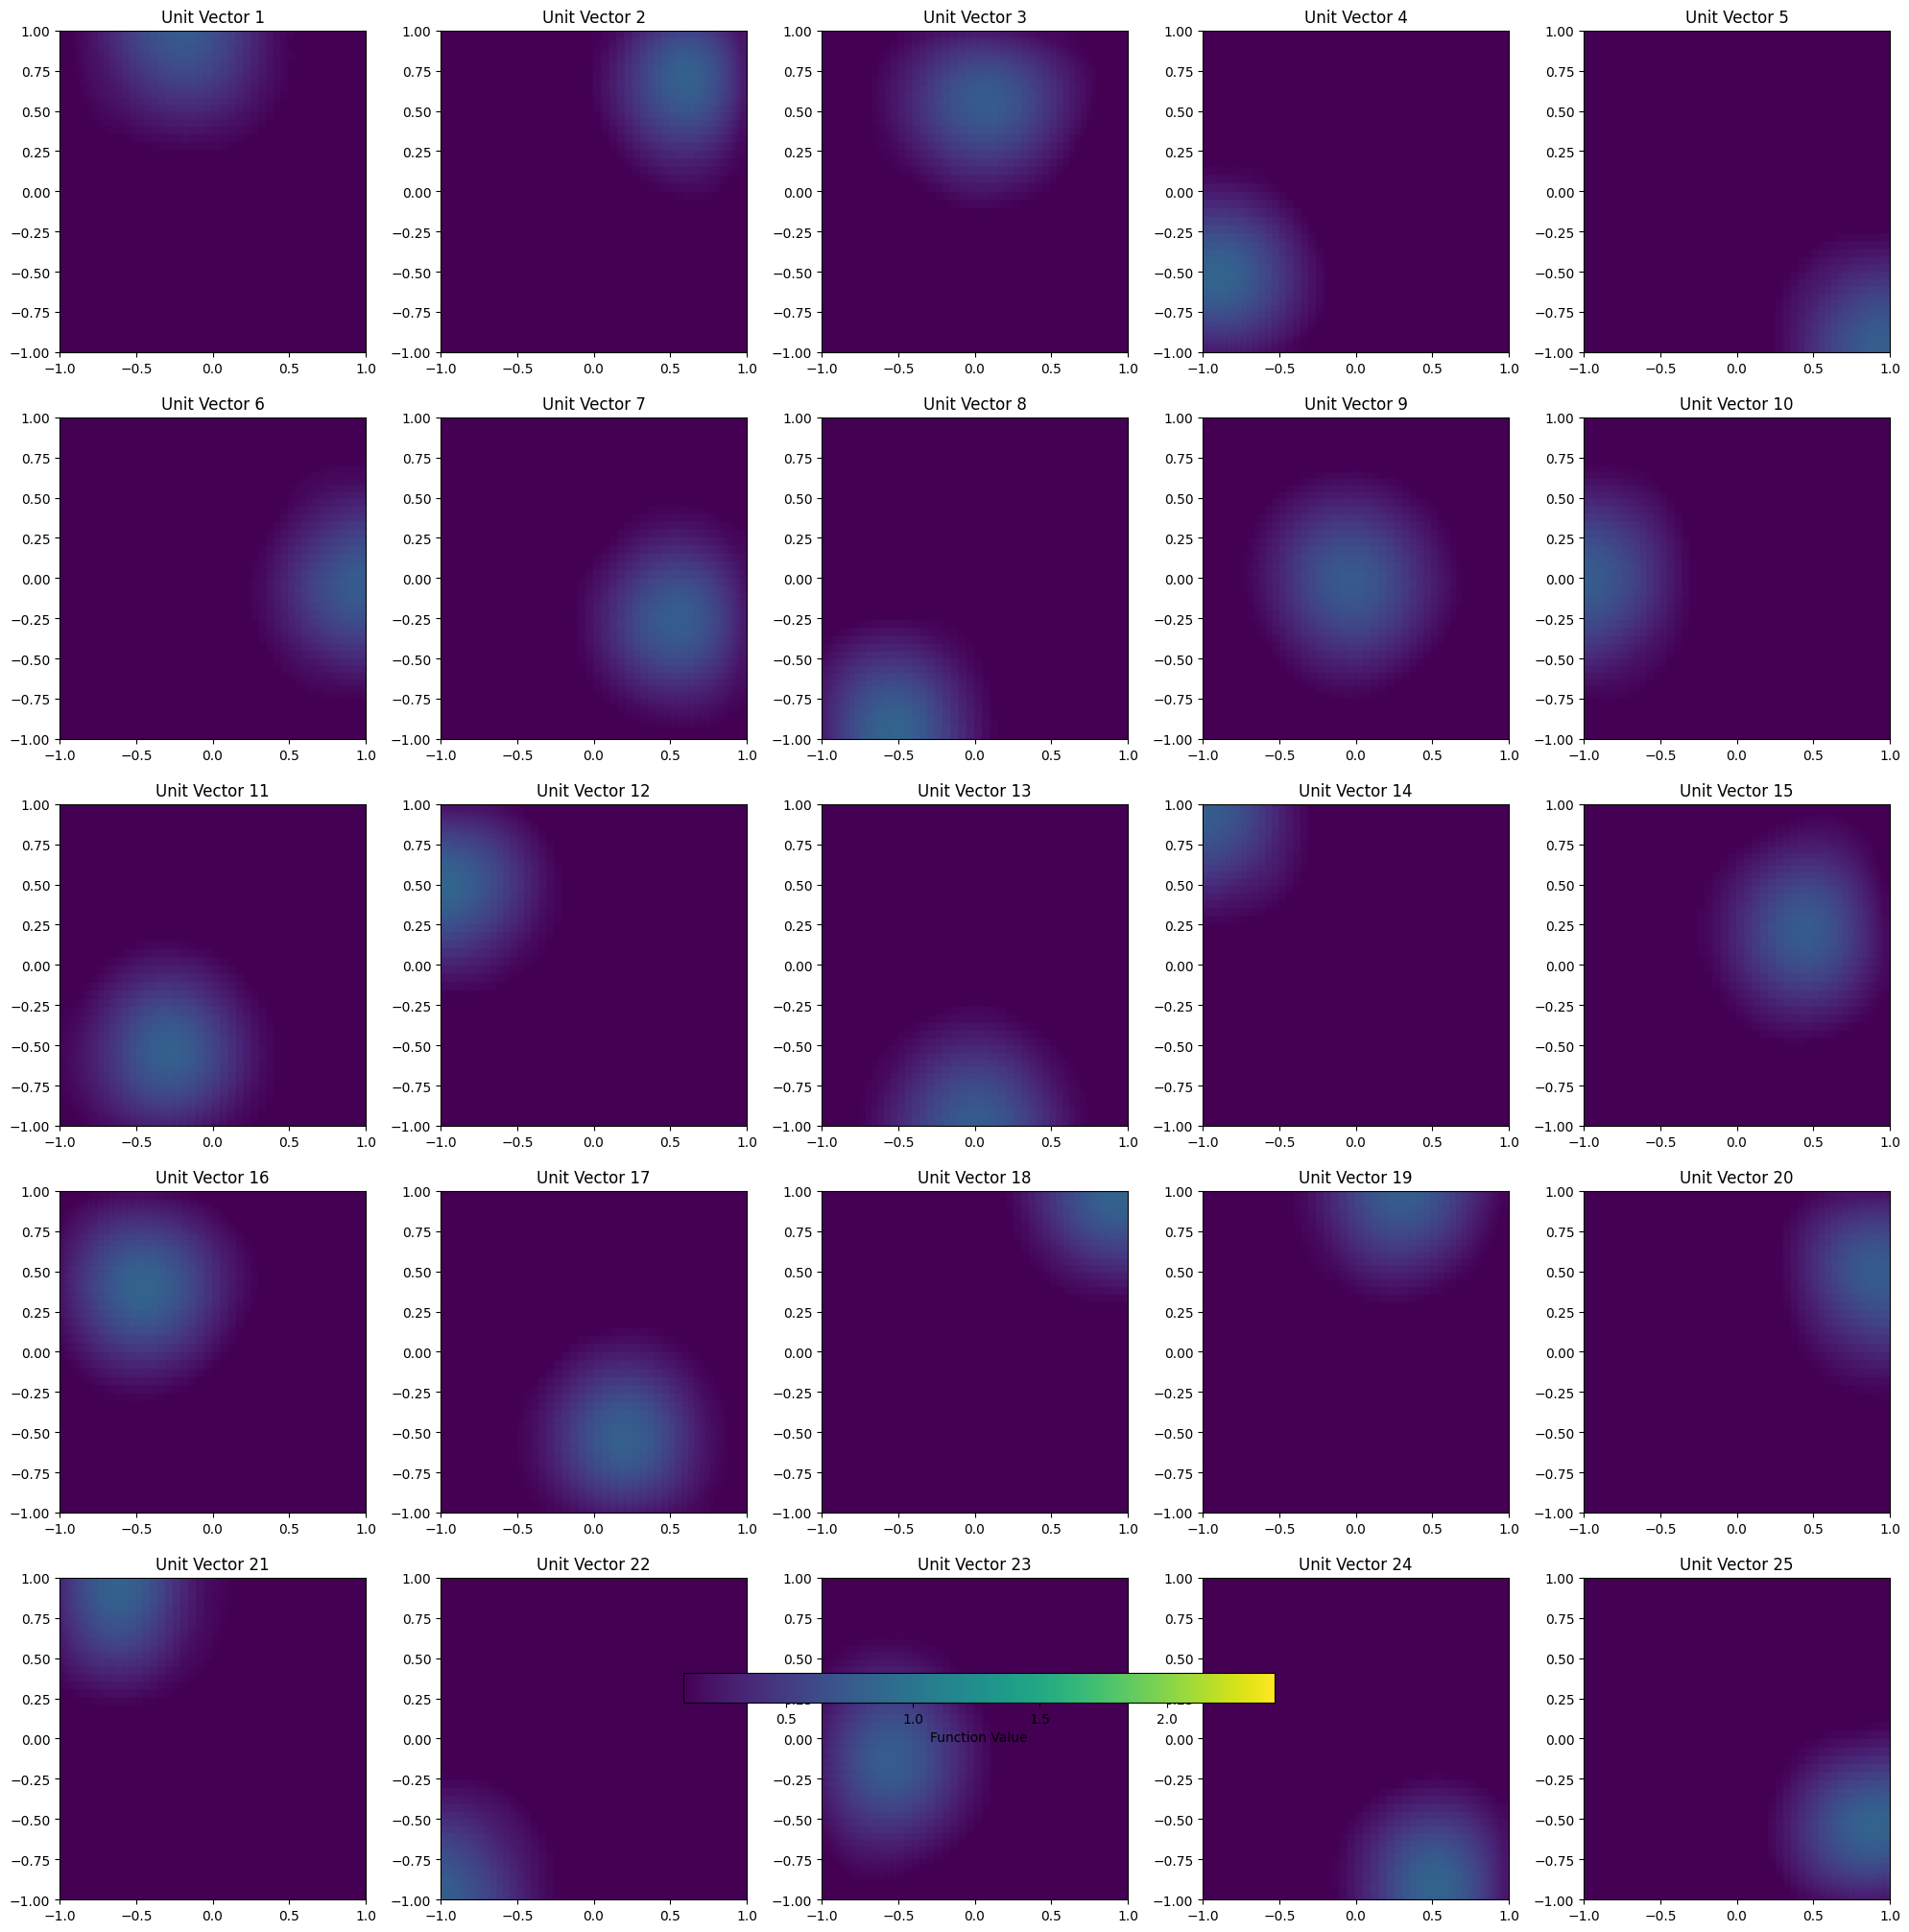

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25):
    estimator.rate = torch.zeros(m).double()
    estimator.rate[i] = 1.0

    function_values = estimator.rate_value(gp.x_acc, 1).cpu().numpy()
    x_coords = gp.x_acc[:, 0].cpu().numpy()
    y_coords = gp.x_acc[:, 1].cpu().numpy()

    ax = axes[i // 5, i % 5]
    scatter = ax.scatter(
        x_coords,
        y_coords,
        c=function_values,
        cmap="viridis",
        vmin=min(gp.y_acc).item(),
        vmax=max(gp.y_acc).item(),
    )
    ax.set_title(f"Unit Vector {i+1}")
    ax.set_xlim(domain.bounds[0][0].item(), domain.bounds[0][1].item())
    ax.set_ylim(domain.bounds[1][0].item(), domain.bounds[1][1].item())

fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, label="Function Value")
plt.tight_layout()
plt.show()

Precomputation finished.
Loading 140 Sampled Data points into approximate intensity model
Approximating the integral of the squared difference between the ground truth intensity and its approximation
tensor(0.5536)


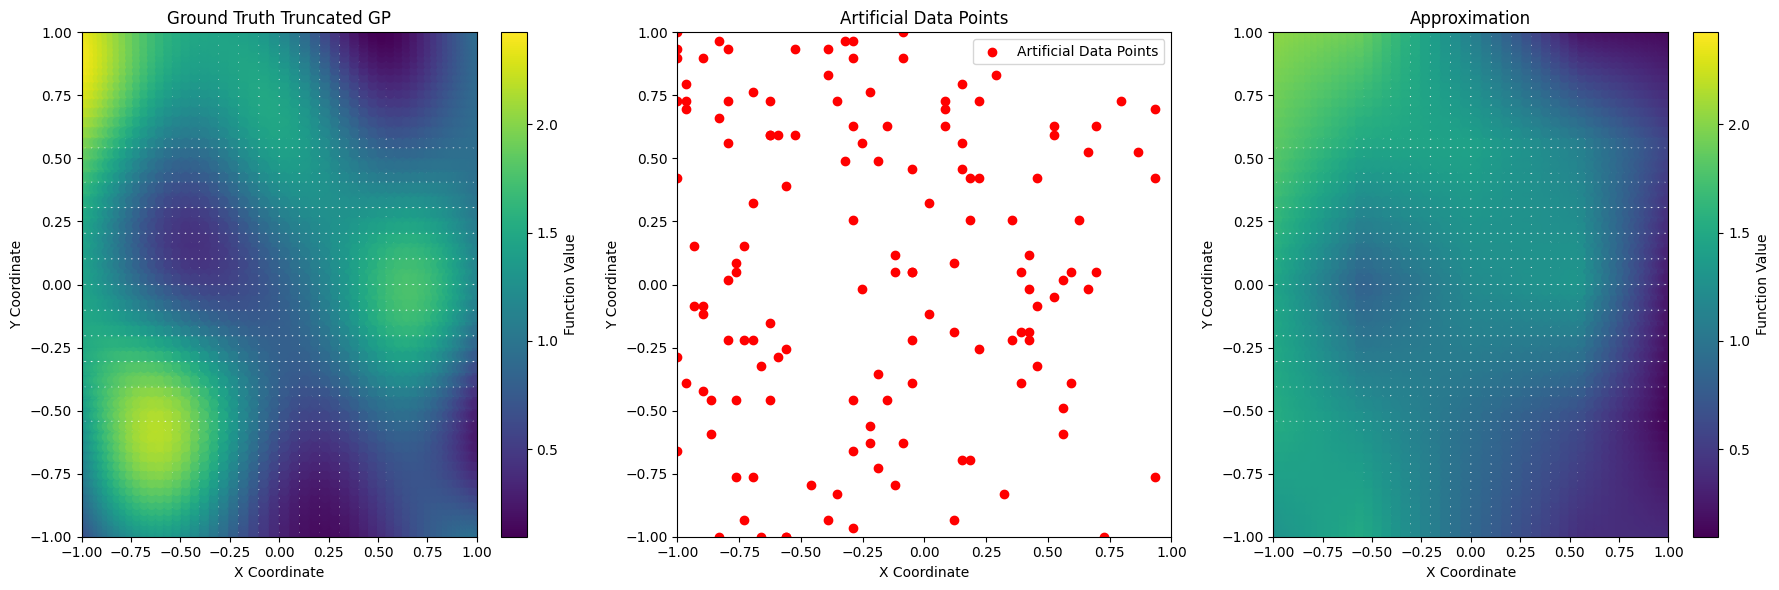

In [8]:
# Define a Triangle Base Estimator


m = 3
min_intensity = 0.0
max_intensity = 1e7
offset = 0.1
jitter = 1e-7
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    basis="custom",
    offset=offset,
    embedding=EfficientTriangleEmbedding(
        2,
        m,
        kernel_object=kernel,
        b=min_intensity,
        B=max_intensity,
        offset=offset,
        s=np.sqrt(jitter),
    ),
)

# Check the triangle base estimator
from validation import check_approx_squared_integral_difference

diff, dataset = check_approx_squared_integral_difference(
    process,
    estimator,
    domain,
    60,
    60,
    dt=dt,
    dataset=dataset if "dataset" in locals() else None,
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

/tmp/ipykernel_99464/1661889985.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


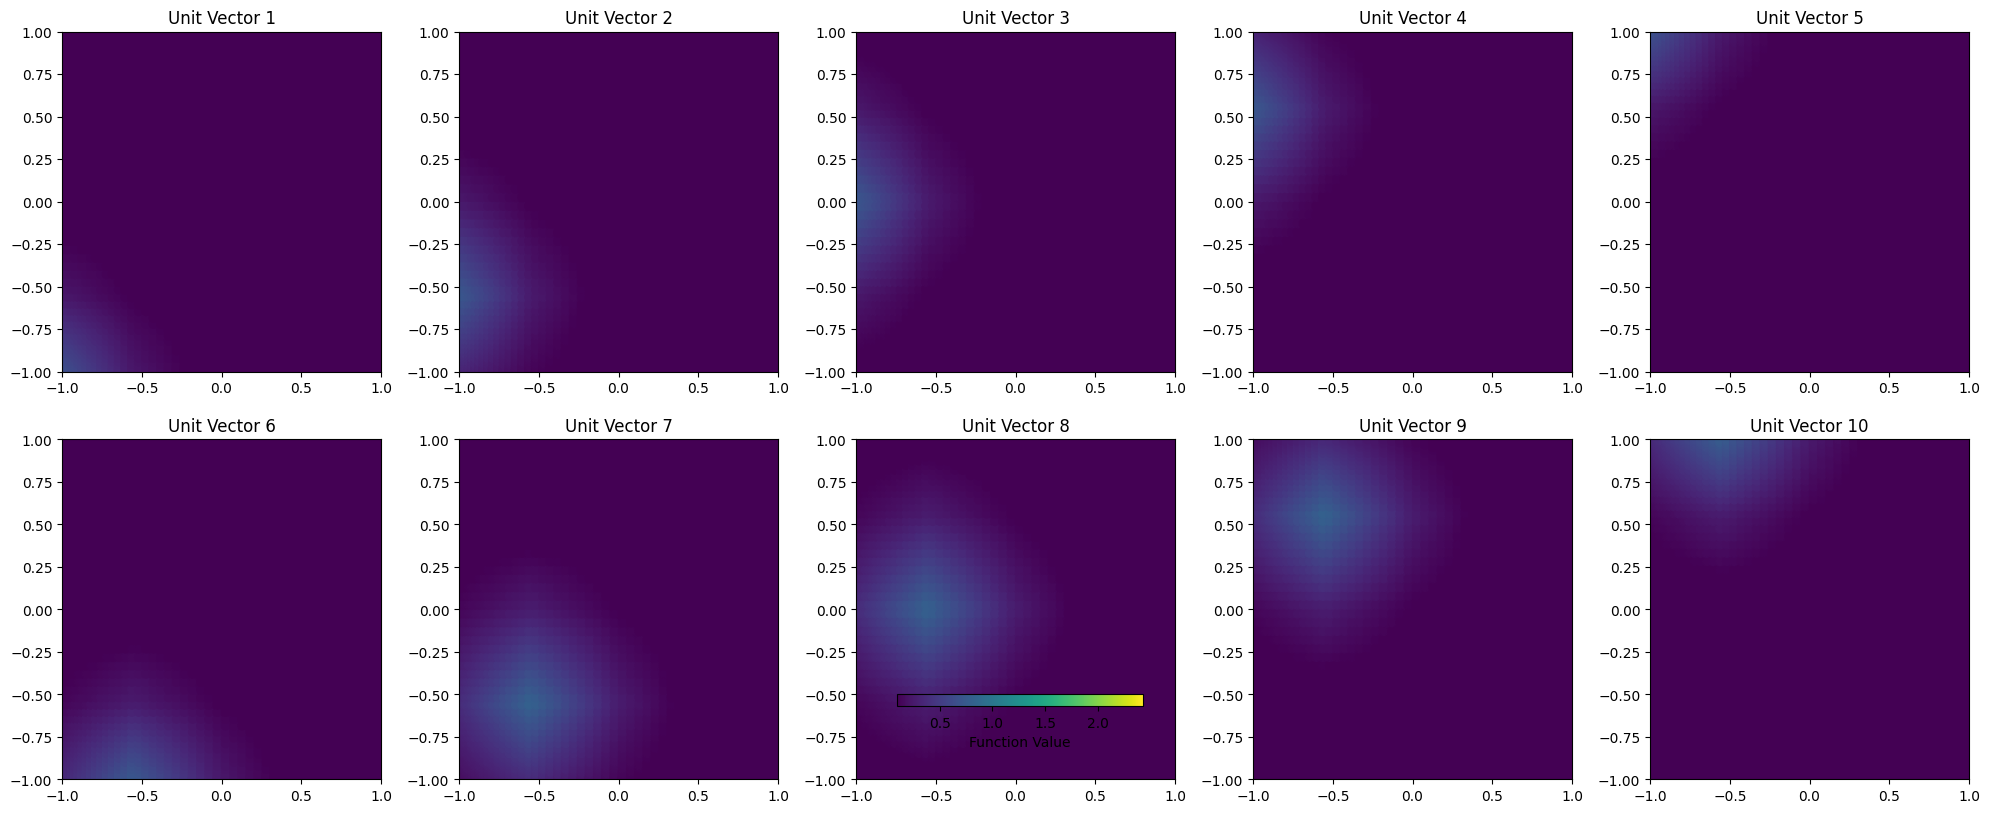

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(10):
    estimator.rate = torch.zeros(m**2).double()
    estimator.rate[i] = 1.0

    function_values = estimator.rate_value(gp.x_acc, 1).cpu().numpy()
    x_coords = gp.x_acc[:, 0].cpu().numpy()
    y_coords = gp.x_acc[:, 1].cpu().numpy()

    ax = axes[i // 5, i % 5]
    scatter = ax.scatter(
        x_coords,
        y_coords,
        c=function_values,
        cmap="viridis",
        vmin=min(gp.y_acc).item(),
        vmax=max(gp.y_acc).item(),
    )
    ax.set_title(f"Unit Vector {i+1}")
    ax.set_xlim(domain.bounds[0][0].item(), domain.bounds[0][1].item())
    ax.set_ylim(domain.bounds[1][0].item(), domain.bounds[1][1].item())

fig.colorbar(
    scatter,
    ax=axes,
    orientation="horizontal",
    fraction=0.02,
    pad=0.1,
    label="Function Value",
)
plt.tight_layout()
plt.show()

Loading 140 Sampled Data points into approximate intensity model


/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  return func(*args, **kwargs)


optimum found
Approximating the integral of the squared difference between the ground truth intensity and its approximation
tensor(0.6127)


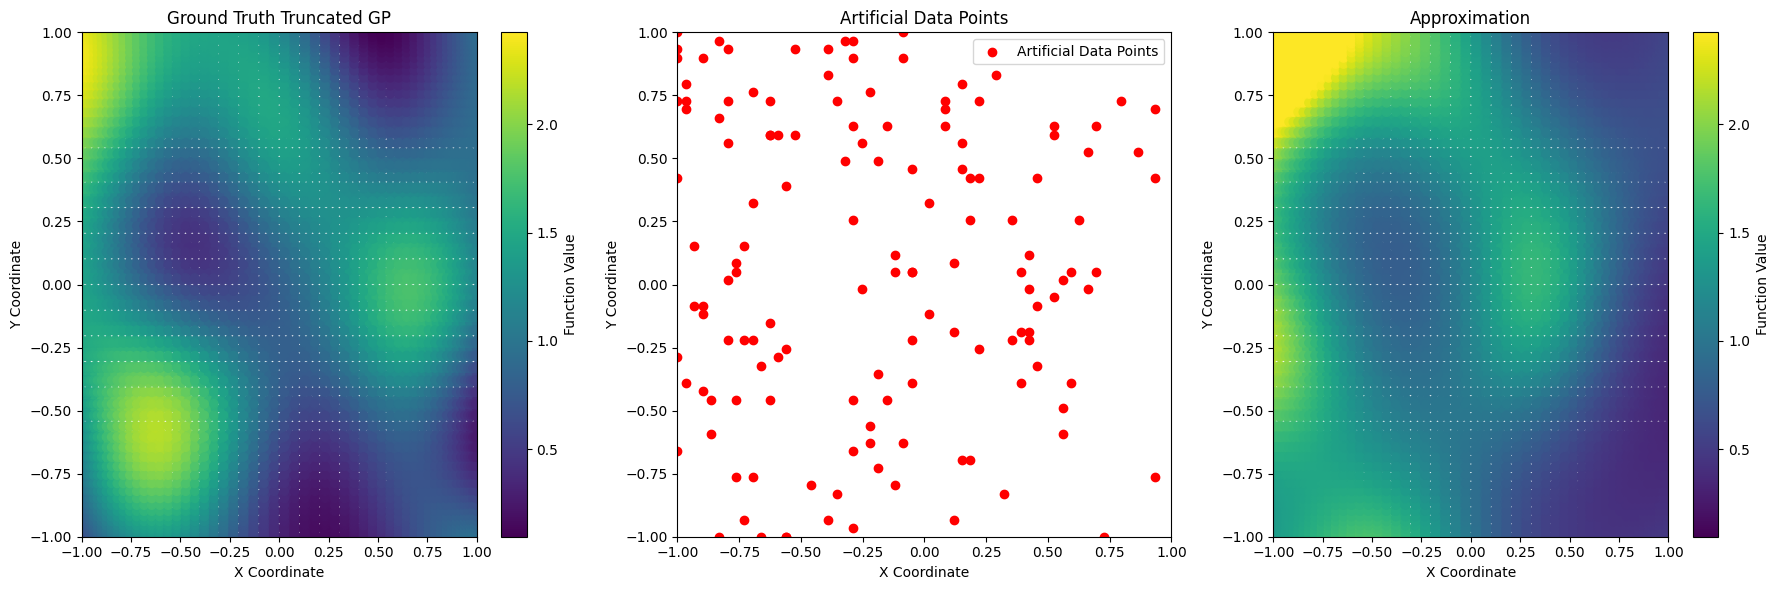

In [10]:
# Log Cox Process Check

from logcox_process import LogCoxProcess

estimator = LogCoxProcess(
    kernel, 60
)

diff, dataset = check_approx_squared_integral_difference(
    process,
    estimator,
    domain,
    60,
    60,
    dt=dt,
    dataset=dataset if "dataset" in locals() else None,
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

In [11]:
function_values = estimator.rate_value(gp.x_acc, 1)
function_values.max()

tensor(4.0348)

Precomputation finished.
Loading 140 Sampled Data points into approximate intensity model
Approximating the integral of the squared difference between the ground truth intensity and its approximation


Burn-In: 100%|██████████| 30/30 [00:02<00:00, 13.64it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]
total number of velocity samples: 1: 


tensor(0.5999)


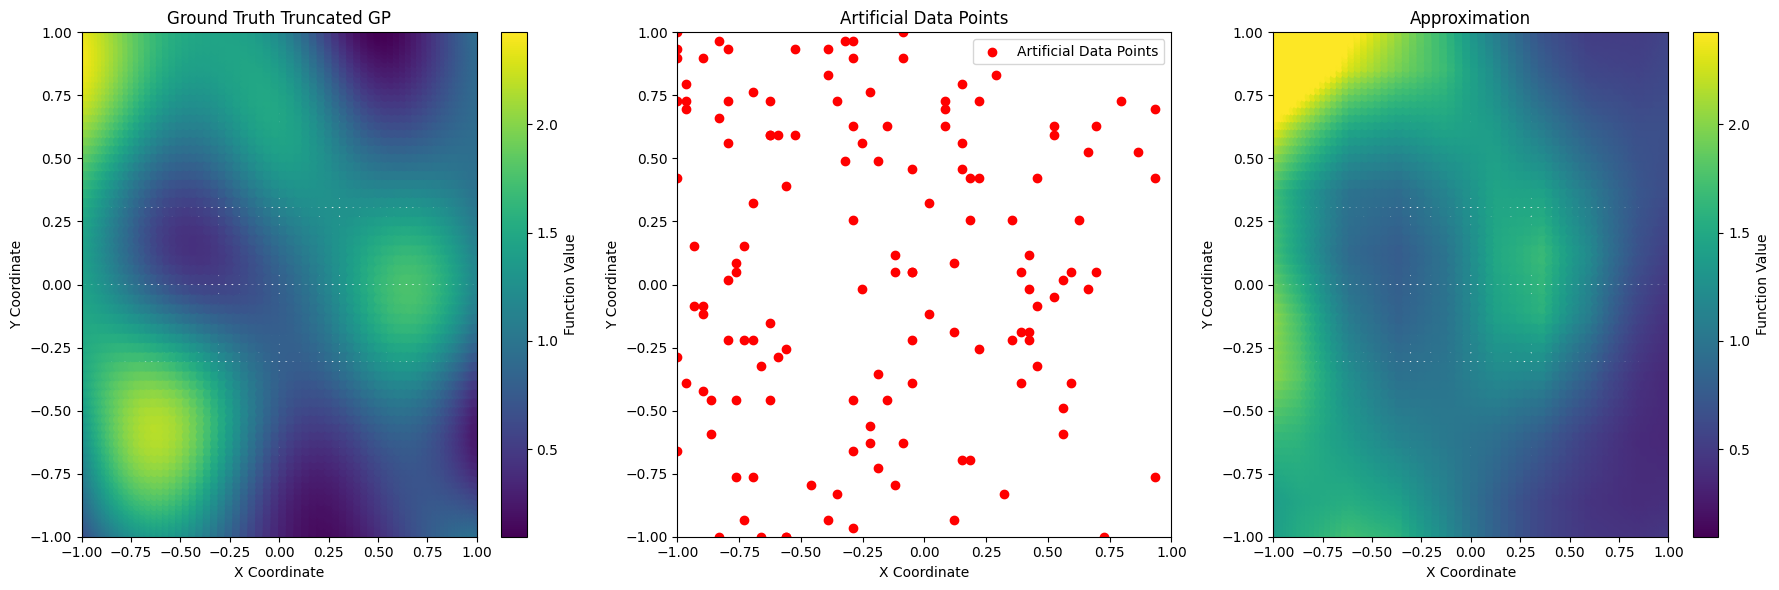

In [12]:
# Exponential GP with basis functions

from stpy.embeddings.optimal_positive_basis import OptimalPositiveBasis
from stpy.point_processes.link_fun_rate_estimator import ExpGaussProcessRateEstimator

m = 10
min_intensity = 1e-8
max_intensity = 1e8
offset = 0.1
jitter = 1e-7
estimator = ExpGaussProcessRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=5
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    offset=offset,
    basis="custom",
    embedding=EfficientTriangleEmbedding(
        2,
        m,
        kernel_object=kernel,
        b=min_intensity,
        B=max_intensity,
        offset=offset,
        s=np.sqrt(jitter),
    ),
)
diff, dataset = check_approx_squared_integral_difference(
    process, estimator, domain, 80, 80, dt=dt , dataset=dataset
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

In [13]:
# Create your own data to put ground truth model where you want it

x = torch.tensor([[0.5, 0.5], [-1, -1], [1, 1], [-1, 1], [1, -1]], dtype=torch.float64)
y = torch.tensor([2, 0, 0, 0, 0], dtype=torch.float64)
gp.gp.fit(x, y.unsqueeze(1))
gp.x_acc = x
gp.y_acc = y
# Create a grid of 50x50 that spans [-1, 1] in 2D
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
x, y = np.meshgrid(x, y)
grid_points = np.vstack([x.ravel(), y.ravel()]).T
grid_points = torch.tensor(grid_points, dtype=torch.float64)
grid_points.shape
sample = gp(grid_points, 1, burn_in=50)

Burn-In: 100%|██████████| 50/50 [00:01<00:00, 32.28it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00, 41.16it/s]
total number of velocity samples: 1: 
